In [1]:
import csv
import gzip
import re

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pybedtools import BedTool

In [4]:
sns.set_style('ticks')

In [5]:
hsap2mmus_ss = dict()

In [6]:
with open("../data/homology/ss/ss_map.csv", 'r') as f:
    reader = csv.DictReader(f)
    next(reader)
    
    for row in reader:
        hsap = row['homo_sapiens']
        mmus = row['mus_musculus']
        
        if mmus == "-":
            continue
        
        h_chrom, h_beg, h_end, h_strand = re.split('[:-]', hsap)
        m_chrom, m_beg, m_end, m_strand = re.split('[:-]', mmus)

        hsap_ss = f"{h_chrom}:{h_beg}:{h_strand}"
        mmus_ss = f"{m_chrom}:{m_beg}:{m_strand}"

        hsap2mmus_ss[hsap_ss] = mmus_ss

In [7]:
orth_type = dict()

In [8]:
with open("../data/homology/exons/hsap_mmus.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        hsap_exon, hsap_type, mmus_exon, mmus_type = row
        
        if hsap_type == "FE":
            orth_type[hsap_exon] = mmus_type

In [9]:
hsap_ss_in_mmus_bed = str()

In [10]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, ss, hsap_score, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon_type != "FE":
            continue

        if "homo_sapiens" in pos_group \
                and "mus_musculus" in neg_group:
            if orth_type.get(exon) != "NE" or ss not in hsap2mmus_ss:
                continue

            mmus_ss = hsap2mmus_ss[ss]

            chrom, *pos = mmus_ss.split(":")
            beg, strand = map(int, pos)

            if strand:
                strand = "+"
            else:
                strand = "-"

            hsap_ss_in_mmus_bed += (
                f"{chrom}\t"
                f"{beg - 10000}\t"
                f"{beg + 10000}\t"
                f".\t"
                f"{beg}\t"
                f"{strand}\n"
            )

In [11]:
gene_bed = str()

In [12]:
with gzip.open("../data/ref/mus_musculus/annot/Mus_musculus.GRCm39.112.gtf.gz", 'rt') as f:
    for row in f:
        if row.startswith("#"):
            continue
        
        row = row.strip("\n").split("\t")
        chrom, _, feat, *pos, _, strand, _, attr = row
        
        beg, end = map(int, pos) 
        beg -= 1
        
        if feat == "gene":
            func = re.search(r'(?<=gene_biotype ")\w+', attr).group(0)
            gene = re.search(r'(?<=gene_id ")\w+', attr).group(0)

            if func != "protein_coding":
                continue

            gene_bed += (
                f"{chrom}\t"
                f"{beg}\t"
                f"{end}\t"
                f"{gene}\t"
                f".\t"
                f"{strand}\n"
            )

In [13]:
bed1 = BedTool(hsap_ss_in_mmus_bed, from_string=True)
bed2 = BedTool(gene_bed, from_string=True)

In [14]:
bed3 = bed1.intersect(bed2, wao=True)

In [15]:
data = list()

In [16]:
for row in bed3:
    junk = row[:6]
    gene = row[6:]
    
    junk, strand = int(junk[4]), junk[5]
    
    if strand == "+":
        gene_beg = int(gene[1])
        d = junk - gene_beg
    else:
        gene_end = int(gene[2])
        d = gene_end - junk

    if abs(d) < 5000:
        data.append(d / 1000)

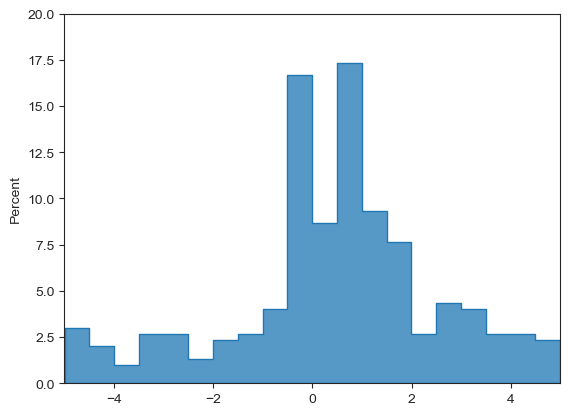

In [17]:
sns.histplot(data, bins=20, stat='percent', element='step')

_ = plt.ylim(0, 20)
_ = plt.xlim(-5, 5)

plt.savefig("figs/main4c.pdf")